In [1]:

import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y

In [3]:
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + '/content/drive/MyDrive/Colab Notebooks/UCI HAR Dataset/UCI HAR Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + '/content/drive/MyDrive/Colab Notebooks/UCI HAR Dataset/UCI HAR Dataset/')

    #zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    #one hot encode y
    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

from sklearn.model_selection import train_test_split

X_train,X_val,y_train_one_hot,y_val_one_hot,y_train,y_val=train_test_split(trainX, trainy_one_hot, trainy,test_size=0.2,random_state=100)

X_train.shape,X_val.shape,y_train_one_hot.shape,y_val_one_hot.shape,y_train.shape,y_val.shape

/tmp/ipython-input-884852549.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-884852549.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-884852549.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-884852549.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp

(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)


((5881, 128, 9), (1471, 128, 9), (5881, 6), (1471, 6), (5881, 1), (1471, 1))

In [4]:
import numpy as np
import tensorflow as tf
from collections import Counter

X_train = X_train.astype('float32')
X_val   = X_val.astype('float32')
testX   = testX.astype('float32')

num_timesteps = X_train.shape[1]
num_features  = X_train.shape[2]
num_classes   = y_train_one_hot.shape[1]

print(f"timesteps={num_timesteps}, features={num_features}, classes={num_classes}")
print("y_train 분포:", Counter(y_train.flatten()))
print("y_val   분포:", Counter(y_val.flatten()))

tf.keras.utils.set_random_seed(100)
np.random.seed(100)


timesteps=128, features=9, classes=6
y_train 분포: Counter({np.int64(5): 1116, np.int64(4): 1093, np.int64(3): 1040, np.int64(0): 983, np.int64(1): 870, np.int64(2): 779})
y_val   분포: Counter({np.int64(5): 291, np.int64(4): 281, np.int64(3): 246, np.int64(0): 243, np.int64(2): 207, np.int64(1): 203})


In [5]:
from tensorflow.keras import layers, models, optimizers

def build_gru_model(timesteps, features, classes, gru_units=64, dense_units=64, dropout_rate=0.3):
    inputs = layers.Input(shape=(timesteps, features))
    x = layers.GRU(gru_units, return_sequences=True)(inputs)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GRU(gru_units)(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Dense(dense_units, activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x)

    outputs = layers.Dense(classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-3),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

gru_model = build_gru_model(num_timesteps, num_features, num_classes)
gru_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 9)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 128, 64)        │        14,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 64)             │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,422 (173.52 KB)

 Trainable params: 44,166 (172.52 KB)

 Non-trainable params: 256 (1.00 KB)

In [6]:
from tensorflow.keras import callbacks
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

es = callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
rlr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5, verbose=1)
ckpt = callbacks.ModelCheckpoint('best_gru.h5', monitor='val_accuracy', save_best_only=True, verbose=1)


In [8]:
history_gru = gru_model.fit(
    X_train, y_train_one_hot,
    validation_data=(X_val, y_val_one_hot),
    epochs=20,
    batch_size=64,
    callbacks=[es, rlr, ckpt]
)


Epoch 1/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4332 - loss: 1.3911
Epoch 1: val_accuracy improved from -inf to 0.38885, saving model to best_gru.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.4342 - loss: 1.3888 - val_accuracy: 0.3889 - val_loss: 1.4547 - learning_rate: 0.0010
Epoch 2/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6730 - loss: 0.7796
Epoch 2: val_accuracy improved from 0.38885 to 0.57852, saving model to best_gru.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.6732 - loss: 0.7790 - val_accuracy: 0.5785 - val_loss: 1.6569 - learning_rate: 0.0010
Epoch 3/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7562 - loss: 0.5832
Epoch 3: val_accuracy improved from 0.57852 to 0.68389, saving model to best_gru.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7565 - loss: 0.5828 - val_accuracy: 0.6839 - val_loss: 1.2469 - learning_rate: 0.0010
Epoch 4/20
89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8510 - loss: 0.4128
Epoch 4: val_accuracy improved from 0.68389 to 0.79062, saving model to best_gru.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8520 - loss: 0.4102 - val_accuracy: 0.7906 - val_loss: 0.6606 - learning_rate: 0.0010
Epoch 5/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9180 - loss: 0.2374
Epoch 5: val_accuracy improved from 0.79062 to 0.91366, saving model to best_gru.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9181 - loss: 0.2372 - val_accuracy: 0.9137 - val_loss: 0.3110 - learning_rate: 0.0010
Epoch 6/20
89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9195 - loss: 0.2239
Epoch 6: val_accuracy improved from 0.91366 to 0.92998, saving model to best_gru.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9199 - loss: 0.2226 - val_accuracy: 0.9300 - val_loss: 0.1521 - learning_rate: 0.0010
Epoch 7/20
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9342 - loss: 0.1716
Epoch 7: val_accuracy improved from 0.92998 to 0.93950, saving model to best_gru.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9343 - loss: 0.1715 - val_accuracy: 0.9395 - val_loss: 0.1308 - learning_rate: 0.0010
Epoch 8/20
89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9336 - loss: 0.1678
Epoch 8: val_accuracy did not improve from 0.93950
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9339 - loss: 0.1669 - val_accuracy: 0.9273 - val_loss: 0.1659 - learning_rate: 0.0010
Epoch 9/20
89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9367 - loss: 0.1571
Epoch 9: val_accuracy did not improve from 0.93950
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9370 - loss: 0.1563 - val_accuracy: 0.9313 - val_loss: 0.1406 - learning_rate: 0.0010
Epoch 10/20
89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9468 - loss: 0.1448
Epoch 10: val_accuracy did not improve from 0.93950
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9469 - loss: 0.1444 - val_accuracy: 0.9361 - val_loss: 0.1231 - learning_rate: 0.0010
Epoch 11/20
92/92 ━━━━━━━━━━━━

92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9301 - loss: 0.1952 - val_accuracy: 0.9490 - val_loss: 0.1228 - learning_rate: 0.0010
Epoch 14/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9405 - loss: 0.1334
Epoch 14: val_accuracy did not improve from 0.94901
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9405 - loss: 0.1334 - val_accuracy: 0.9429 - val_loss: 0.1244 - learning_rate: 0.0010
Epoch 15/20
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9411 - loss: 0.1388
Epoch 15: val_accuracy did not improve from 0.94901
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9412 - loss: 0.1386 - val_accuracy: 0.9279 - val_loss: 0.1753 - learning_rate: 0.0010
Epoch 16/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9402 - loss: 0.1383
Epoch 16: val_accuracy did not improve from 0.94901
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9403 - loss: 0.1382 - val_accuracy: 0.9402 - val_loss: 0.1432 - learning_rate: 0.0010
Epoch 17/20
89/92 ━━━━━━━━

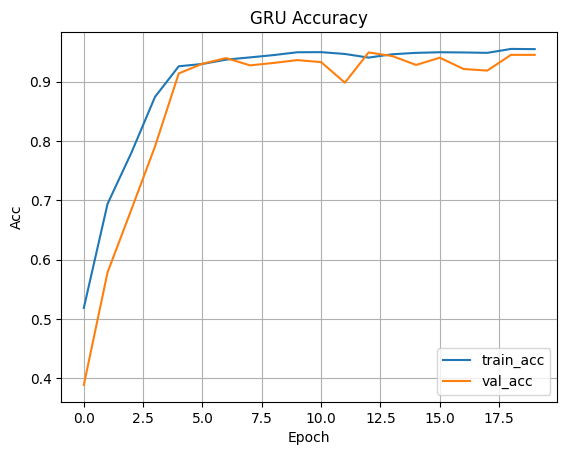

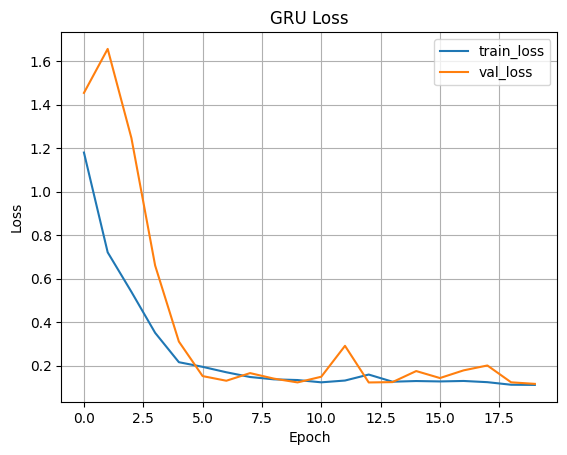

In [9]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history_gru.history['accuracy'], label='train_acc')
plt.plot(history_gru.history['val_accuracy'], label='val_acc')
plt.legend(); plt.title('GRU Accuracy'); plt.xlabel('Epoch'); plt.ylabel('Acc'); plt.grid(True)
plt.show()

plt.figure()
plt.plot(history_gru.history['loss'], label='train_loss')
plt.plot(history_gru.history['val_loss'], label='val_loss')
plt.legend(); plt.title('GRU Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.grid(True)
plt.show()


[VAL] loss=0.1228, acc=0.9490
[TEST] loss=0.2691, acc=0.9104

[VAL] Classification Report (GRU)
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       243
           1     0.9950    0.9901    0.9926       203
           2     0.9904    1.0000    0.9952       207
           3     0.8531    0.8496    0.8513       246
           4     0.8719    0.8719    0.8719       281
           5     1.0000    1.0000    1.0000       291

    accuracy                         0.9490      1471
   macro avg     0.9517    0.9519    0.9518      1471
weighted avg     0.9489    0.9490    0.9490      1471



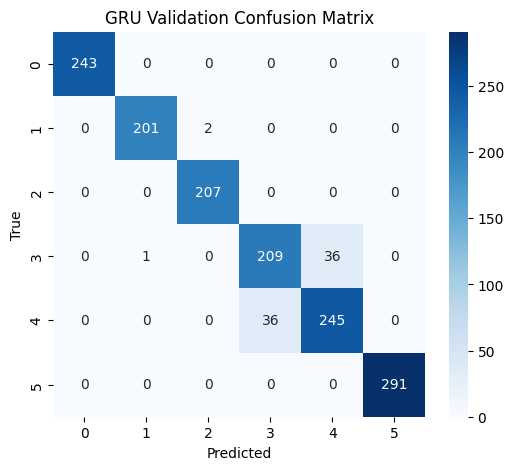

In [10]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

gru_model.load_weights('best_gru.h5')

val_loss, val_acc = gru_model.evaluate(X_val, y_val_one_hot, verbose=0)
test_loss, test_acc = gru_model.evaluate(testX, testy_one_hot, verbose=0)
print(f"[VAL] loss={val_loss:.4f}, acc={val_acc:.4f}")
print(f"[TEST] loss={test_loss:.4f}, acc={test_acc:.4f}")

val_pred = gru_model.predict(X_val, verbose=0)
val_pred_label = np.argmax(val_pred, axis=1)

print("\n[VAL] Classification Report (GRU)")
print(classification_report(y_val.flatten(), val_pred_label, digits=4))

cm = confusion_matrix(y_val.flatten(), val_pred_label)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('GRU Validation Confusion Matrix')
plt.xlabel('Predicted'); plt.ylabel('True')
plt.show()
